# Assignment 5. Tools for Machine Learning Workflow

*Foundations of Data Science*  
*Dr. Khalaj (Fall 2023)*  
*For your questions refer to @amirsoleix on Telegram*


<div class="box">
  <table>
    <tr>
      <th colspan="2">Personal Info</th>
    </tr>
    <tr>
      <td>First Name:</td>
      <td>Ali</td>
    </tr>
    <tr>
      <td>Last Name:</td>
      <td>Nikkhah</td>
    </tr>
    <tr>
      <td>Student Number:</td>
      <td>99102445</td>
    </tr>
    <tr>
      <td>Git:</td>
      <td><a href="https://github.com/AliNikkhah2001/DataScience02" target="_blank">https://github.com/AliNikkhah2001/DataScience02</a></td>
    </tr>
  </table>
</div>



## 1 Retrieval of Data

Consider a content delivery website. On the user end, when you want to find what you want in such websites, you probably use the search bar or the navigation menu on the top, or alternatively, let Google find you the best matching result using its proprietary indexing (which by the way, usually works better than the website's own search bar!).  

But as a data engineer, the level of detail and comprehensiveness of data matters more as you are looking for insight rather than single matches. It allows you to analyze different aspects of social behavior on different localities and make informed decisions based on that.  

Consider that you are a data analyst for a software team given the task of analyzing market demand for your upcoming product. In this scenario, one of the best ways is to track activity on forums and goto places where people get their software from. This can range from different online stores and websites, to community forums and related social media posts.  

After discussion, you have found that `downloadha.com` is one of the main sources local people use for downloading their software hence you want to analyze the demand for different categories of softwares.

### 1.1 Data Version Control
Since data is constantly changing, logging the current state of the data is a necessity. It is required that we track the changes and act upon them when necessary, and a prerequisite to knowing when changes occur is to be aware of what changes are logged in our systems and what changes are not. One of the tools used for version controlling the data is `DVC`. Read the documents and use it in the process.

### DVC

In [1]:
%%capture
!pip install dvc


In [ ]:
!git init
!dvc init

In [3]:

!dvc status

Data and pipelines are up to date.                                              


### 1.2 Crawling

List the information related to each software for the last 1000 softwares listed on the mentioned website. The website uses pagination with 10 results available on each page. So for reaching 1000 softwares you need to crawl `downloadha.com/page/1/` up to `downloadha.com/page/100/`. For having a safety threshold in case of crawler failure (a common problem in crawlers), you can extend it to 2000 items to be sure you are left with 1000 decent instances.  

This website is chosen in particular for its easy access to database. Remember that as systems gets more advanced accessing older data becomes harder. For comparison try to search for books that were listed on Amazon before 2020 and look at the URL!  

The data for each software should include:
- Name
- Platform
- Category and Subcategories
- Description
- Date of Creation
- Author
- Visit Count
- Comment Count
- Tags

Save the data on a CSV file and upload it with your delivery. You can use libraries like Beautiful Soup and Scrapy for the crawling task.

In [20]:
import requests

def check_connection(url):
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()  # Check for HTTP errors
        print(f"Connection to {url} successful. Status code: {response.status_code}")
    except requests.exceptions.RequestException as e:
        print(f"Error during connection to {url}: {e}")

# List of sample websites
websites = [
    "https://www.google.com",
    "https://www.facebook.com",
    "https://www.varzesh3.com"
]

# Check connection to each website
for website in websites:
    check_connection(website)


Connection to https://www.google.com successful. Status code: 200
Error during connection to https://www.facebook.com: HTTPSConnectionPool(host='www.facebook.com', port=443): Read timed out. (read timeout=10)
Connection to https://www.varzesh3.com successful. Status code: 200


In [ ]:
import requests
from bs4 import BeautifulSoup
import csv
from tqdm.notebook import tqdm
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

def extract_page_data(url, session):
    try:
        response = session.get(url, timeout=10)  # Adjust the timeout value as needed
        response.raise_for_status()  # Check for HTTP errors

        soup = BeautifulSoup(response.text, 'html.parser')

        software_list = []
        articles = soup.find('main', {'id': 'main'}).find_all('article')
        for article in articles:
            software_data = {}
            software_data['Name'] = article.find('h2').text.strip()
            software_data['Category'] = article.find('div', class_='post-categories').find_all('a')
            software_data['Description'] = article.find('div', class_='entry-content').find_all('p')[0].text.strip()
            software_data['Date of Creation'] = article.find('span', class_='posted-on').text.strip()
            software_data['Author'] = article.find('span', class_='author').text.strip()
            software_data['Visit Count'] = article.find_all('div', class_='post-view')[0].text.strip()
            software_data['Comment Count'] = article.find_all('div', class_='post-view')[1].text.strip()
            software_data['Tags'] = ', '.join(tag.text.strip() for tag in article.find('div', class_='post-tags').find_all('a'))
            software_list.append(software_data)

        return software_list
    except requests.exceptions.RequestException as e:
        print(f"Error during request: {e}")
        return []

def crawl_website(start_page, end_page):
    all_software_data = []

    session = requests.Session()
    retries = Retry(total=5, backoff_factor=1, status_forcelist=[500, 502, 503, 504])
    session.mount('http://', HTTPAdapter(max_retries=retries))
    session.mount('https://', HTTPAdapter(max_retries=retries))

    for page_number in tqdm(range(start_page, end_page + 1), desc='Crawling Pages'):
        url = f'https://downloadha.com/page/{page_number}/'
        page_data = extract_page_data(url, session)
        all_software_data.extend(page_data)

    return all_software_data

def save_to_csv(data, filename):
    keys = data[0].keys()

    with open(filename, 'w', newline='', encoding='utf-8') as csv_file:
        writer = csv.DictWriter(csv_file, fieldnames=keys)
        writer.writeheader()
        writer.writerows(data)

# Crawl the website and save data to CSV
start_page = 1
end_page = 500  
output_filename = 'software_data.csv'

all_data = crawl_website(start_page, end_page)

if all_data:
    print(f"Data successfully retrieved from {start_page} to {end_page} pages.")
    save_to_csv(all_data, output_filename)
else:
    print("No data retrieved. Please check your connection or the website structure.")


In [88]:

csv_file_path = 'software_data.csv'

all_data = pd.read_csv(csv_file_path)

# Display the first few rows of the DataFrame to verify the data
print(all_data.info())
print(all_data.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Name              3000 non-null   object
 1   Category          3000 non-null   object
 2   Description       2998 non-null   object
 3   Date of Creation  3000 non-null   object
 4   Author            3000 non-null   object
 5   Visit Count       3000 non-null   object
 6   Comment Count     3000 non-null   object
 7   Tags              2996 non-null   object
dtypes: object(8)
memory usage: 187.6+ KB
None
                                                   Name  \
2651  دانلود بازی Wolfstride v1.2 برای کامپیوتر – نس...   
1219  دانلود بازی Skye Tales برای کامپیوتر – نسخه فش...   
158   دانلود بازی Hedon Bloodrite – Incremedital برا...   
2839  دانلود Snagit 2022.0.2 Build 16407 Win/macOS –...   
2204  دانلود بازی Fire Commander v1.1 برای کامپیوتر ...   

                                

### 1.3 Database (Bonus)  
Use a relational database like MySQL, SQLite or a non-relational instance like MongoDB for archiving the data. You don't need online implementation of this and can create a local instance of database and upload the relevant files with your delivery.

In [55]:
from bs4.element import ResultSet

def create_database():
    with sqlite3.connect('software_data.db') as connection:
        cursor = connection.cursor()

        # Create 'software' table
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS software (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                Name TEXT,
                Platform TEXT,
                Description TEXT,
                Date_of_Creation TEXT,
                Author TEXT,
                Visit_Count TEXT,
                Comment_Count TEXT
            )
        ''')

        # Create 'categories' table
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS categories (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                Name TEXT
            )
        ''')

        # Create 'tags' table
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS tags (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                Name TEXT
            )
        ''')

        # Create 'software_category' table
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS software_category (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                software_id INTEGER,
                category_id INTEGER,
                FOREIGN KEY (software_id) REFERENCES software(id),
                FOREIGN KEY (category_id) REFERENCES categories(id)
            )
        ''')

        # Create 'software_tag' table
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS software_tag (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                software_id INTEGER,
                tag_id INTEGER,
                FOREIGN KEY (software_id) REFERENCES software(id),
                FOREIGN KEY (tag_id) REFERENCES tags(id)
            )
        ''')


    connection.commit()
    connection.close()


def save_to_database(data):
    connection = sqlite3.connect('software_data.db')
    cursor = connection.cursor()

    for software_data in data:
        # Extract individual categories and insert them into 'categories' table
        categories = []
        category_elements = software_data['Category']
        if isinstance(category_elements, ResultSet):
            # Iterate over each category element and extract text
            categories = [category.text.strip() for category in category_elements]
        else:
            # Assume 'Category' is already a string, split it and strip
            categories = [category.strip() for category in category_elements.split(',')]

        category_ids = []
        for category in categories:
            # Insert category into 'categories' table and get the ID
            cursor.execute('''
                INSERT OR IGNORE INTO categories (Name) VALUES (?)
            ''', (category,))
            category_id = cursor.execute('''
                SELECT id FROM categories WHERE Name = ?
            ''', (category,)).fetchone()[0]
            category_ids.append(category_id)

        # Update 'software' table with the category IDs
        cursor.execute('''
            INSERT INTO software (Name, Platform, Description, Date_of_Creation, Author, Visit_Count, Comment_Count)
            VALUES (?, ?, ?, ?, ?, ?, ?)
        ''', (
            software_data['Name'],
            software_data.get('Platform', ''),
            software_data['Description'],
            software_data['Date of Creation'],
            software_data['Author'],
            software_data['Visit Count'],
            software_data['Comment Count'],
        ))

        # Get the ID of the last inserted software entry
        software_id = cursor.lastrowid

        # Insert category associations into 'software_category' table
        for category_id in category_ids:
            cursor.execute('''
                INSERT INTO software_category (software_id, category_id) VALUES (?, ?)
            ''', (software_id, category_id))

        # Extract individual tags and insert them into 'tags' table
        tags = [tag.strip() for tag in software_data['Tags'].split(',')]
        tag_ids = []
        for tag in tags:
            # Insert tag into 'tags' table and get the ID
            cursor.execute('''
                INSERT OR IGNORE INTO tags (Name) VALUES (?)
            ''', (tag,))
            tag_id = cursor.execute('''
                SELECT id FROM tags WHERE Name = ?
            ''', (tag,)).fetchone()[0]
            tag_ids.append(tag_id)

        # Insert tag associations into 'software_tag' table
        for tag_id in tag_ids:
            cursor.execute('''
                INSERT INTO software_tag (software_id, tag_id) VALUES (?, ?)
            ''', (software_id, tag_id))

    connection.commit()
    connection.close()


In [56]:
start_page = 1
end_page = 300
all_data = crawl_website(start_page, end_page)
create_database()
if all_data:
    print(f"Data successfully retrieved from {start_page} to {end_page} pages.")
    save_to_database(all_data)
    print("Data saved to the SQLite database.")
else:
    print("No data retrieved. Please check your connection or the website structure.")

Crawling Pages:   0%|          | 0/300 [00:00<?, ?it/s]

Data successfully retrieved from 1 to 300 pages.
Data saved to the SQLite database.


In [12]:
!dvc add software_data.csv

⠋ Checking graph                                       core>
Adding...                                                                       
!
                                                                                
!
  0% Checking cache in '/Users/alinikkhah/Desktop/HW5/.dvc/cache/files/md5'| |0/
                                                                                
!
  0%|          |Checking out /Users/alinikkhah/Desktop0/? [00:00<?,    ?files/s]
  0%|          |Checking out /Users/alinikkhah/Desktop0/1 [00:00<?,    ?files/s]
100% Adding...|████████████████████████████████████████|1/1 [00:00, 67.44file/s]

To track the changes with git, run:

	git add software_data.csv.dvc

To enable auto staging, run:

	dvc config core.autostage true


In [13]:
import sqlite3

def display_samples():
    with sqlite3.connect('software_data.db') as connection:
        cursor = connection.cursor()

        # Query to fetch some samples from the 'software' table along with associated tags and categories
        query = '''
            SELECT s.Name, s.Platform, s.Description, s.Date_of_Creation, s.Author, s.Visit_Count, s.Comment_Count,
                   GROUP_CONCAT(DISTINCT c.Name) AS Categories,
                   GROUP_CONCAT(DISTINCT t.Name) AS Tags
            FROM software s
            LEFT JOIN software_category sc ON s.id = sc.software_id
            LEFT JOIN categories c ON sc.category_id = c.id
            LEFT JOIN software_tag st ON s.id = st.software_id
            LEFT JOIN tags t ON st.tag_id = t.id
            GROUP BY s.id
            LIMIT 5
        '''

        # Execute the query
        cursor.execute(query)

        # Fetch the results
        samples = cursor.fetchall()

        # Print the results
        print("\nSamples of Stored Data:")
        for sample in samples:
            print("\nSoftware Name:", sample[0])
            print("Platform:", sample[1])
            print("Description:", sample[2])
            print("Date of Creation:", sample[3])
            print("Author:", sample[4])
            print("Visit Count:", sample[5])
            print("Comment Count:", sample[6])
            print("Categories:", sample[7])
            print("Tags:", sample[8])

# Call the function to display samples
display_samples()



Samples of Stored Data:

Software Name: دانلود بازی TEKKEN 8 برای کامپیوتر – نسخه RUNE
Platform: 
Description: بازی Tekken 8 (تکن ۸) توسط بندای نامک توسعه یافته و منتشر می‌شود. این هشتمین قسمت اصلی در سری تکن محسوب می‌شود و دنباله‌ای مستقیم بر بازی Tekken 7 است که سال ۲۰۱۵ عرضه شده بود. داستان تکن ۸ ادامه داستان نسخه قبلی بعدی و شش ماه بعد از آن را روایت می‌کند. جین کازاما، قهرمان بازی، همچنان در تلاش است تا از شیطان درون خود جلوگیری کند. او با کمک دوستان و متحدانش، باید جلوی کازویا میشیما که پدرش است را بگیرد. میشیما اکنون به یک هیولای قدرتمند تبدیل شده است.
Date of Creation: Posted on ۱۴۰۲/۱۱/۰۵۱۴۰۲/۱۱/۰۶
Author: حسین
Visit Count: 2,807بازدید
Comment Count: بدون نظر
Categories: آرکید,بازی اکشن,بازی کامپیوتر
Tags: بازی AAA,دانلود TEKKEN 8 برای کامپیوتر,دانلود بازی TEKKEN 8,دانلود بازی TEKKEN 8 کرک شده,دانلود بازی تکن 8 برای pc,دانلود تکن 8 برای کامپیوتر

Software Name: دانلود بازی Palworld برای کامپیوتر – نسخه Early-Access
Platform: 
Description: بازی Palworld اثر ترند این روزهای صنع

## 2 Exploratory Data Analysis

Report the information about the data in charts. This includes converting the data into a consistent format, including the dates, descriptions, etc.  

More attention needs to be put toward the default categorization the website has provided. As it is given in a breadcrumb format, you need to breakdown the category to extract different levels. You need to deliver the following data/visualizations for this part:

- Graph of different categories and subcategories of the softwares available on the website. Some of the material listed might not be software but videos. For those, use the default category of the website to create a new section. **Treat videos, educational packages, etc. just as other categories of software. Do not exclude them from the data.**

In [87]:
import re

def extract_numeric_count(text):
    match = re.search(r'\d{1,3}(?:,\d{3})*', text)
    if match:
        return int(match.group().replace(',', ''))
    return 0

# Example usage:
comment_count_text = "20,144بازدید"
visit_count_text = "2,305بازدید"

comment_count = extract_numeric_count(comment_count_text)
visit_count = extract_numeric_count(visit_count_text)

print(f"Comment Count: {comment_count}")
print(f"Visit Count: {visit_count}")


Comment Count: 20144
Visit Count: 2305


In [79]:

def extract_tags(description):
    tag_mapping = {
        'PC': ['Windows','کامپیوتر','PC'],
        'MAC': ['MAC', 'Apple','مک','مکینتاش','mac','osx'],
        'LINUX': ['Linux', 'Ubuntu','لینوکس'],
        'XBOX360': ['XBOX360', 'Xbox 360','xbox','XBox'],
        'XBOXONE': ['XBOXONE', 'Xbox One'],
        'PS5': ['PS5', 'PlayStation 5','ps5'],
        'PS4': ['PS4', 'PlayStation 4','ps4'],
        'PS3': ['PS3', 'PlayStation 3','ps3'],
        'Multimedia':['آموزش','مشاوره','مجله','والپیپر','موسیقی','کلیپ'],
        
    }
    tags = []
    for tag, categories in tag_mapping.items():
        if any(category in description for category in categories):
            tags.append(tag)
    return tags

In [80]:
num_data=0
for index, software_data in all_data.iterrows():
    description_tags = extract_tags(software_data['Name'])
    all_tags = list(set(description_tags ))
    software_data['Platform'] = extract_platform(all_tags)
    if not(description_tags):
    #print(software_data)
        all_data.drop(index, inplace=True)
        
    else:
        num_data+=1
        all_data.at[index, 'Platform'] = description_tags[0]
        
        
print(f"Number of rows with non-empty description_tags: {num_data}")
    

Number of rows with non-empty description_tags: 2900


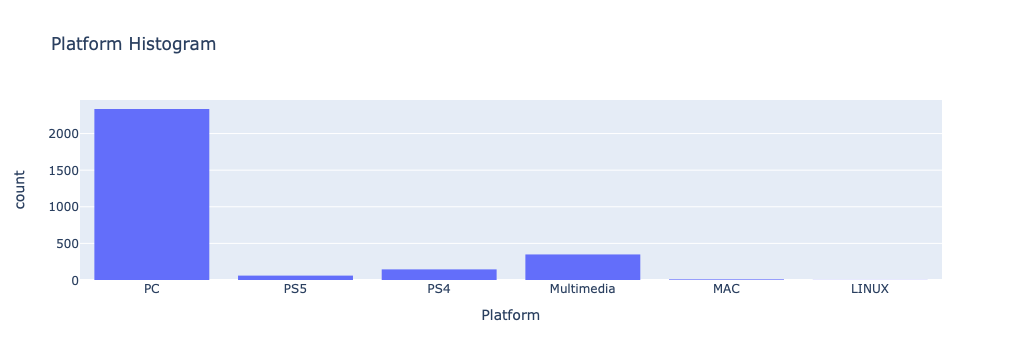

In [81]:
import plotly.express as px

# Assuming 'all_data' is your DataFrame with the 'Platform' column
fig = px.histogram(all_data, x='Platform', title='Platform Histogram')

# Show the plot
fig.show() 


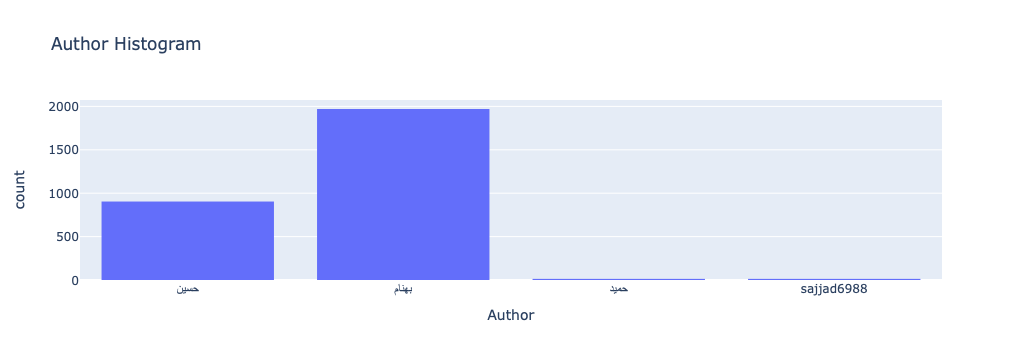

In [82]:
import plotly.express as px

# Assuming 'all_data' is your DataFrame with the 'Platform' column
fig = px.histogram(all_data, x='Author', title='Author Histogram')

# Show the plot
fig.show() 


In [83]:
import re

def extract_numeric_count(text):
    match = re.search(r'\d{1,3}(?:,\d{3})*', text)
    if match:
        return int(match.group().replace(',', ''))
    return 0

# Example usage:
comment_count_text = "20,144بازدید"
visit_count_text = "2,305بازدید"

comment_count = extract_numeric_count(comment_count_text)
visit_count = extract_numeric_count(visit_count_text)

print(f"Comment Count: {comment_count}")
print(f"Visit Count: {visit_count}")


Comment Count: 20144
Visit Count: 2305


In [102]:
import pandas as pd
import re
def extract_numeric_count(text):
    match = re.search(r'\d{1,3}(?:,\d{3})*', str(text))
    if match:
        return int(match.group().replace(',', ''))
    return 0
all_data['Visit Count'] = all_data['Visit Count'].apply(extract_numeric_count)
all_data['Comment Count'] = all_data['Comment Count'].apply(extract_numeric_count)
print(all_data[['Visit Count', 'Comment Count']])


      Visit Count  Comment Count
0             226              0
1             662             15
2             347             38
3             632              0
4             188              0
...           ...            ...
2995          144              0
2996          827              0
2997          204             47
2998          334              0
2999          507              2

[3000 rows x 2 columns]


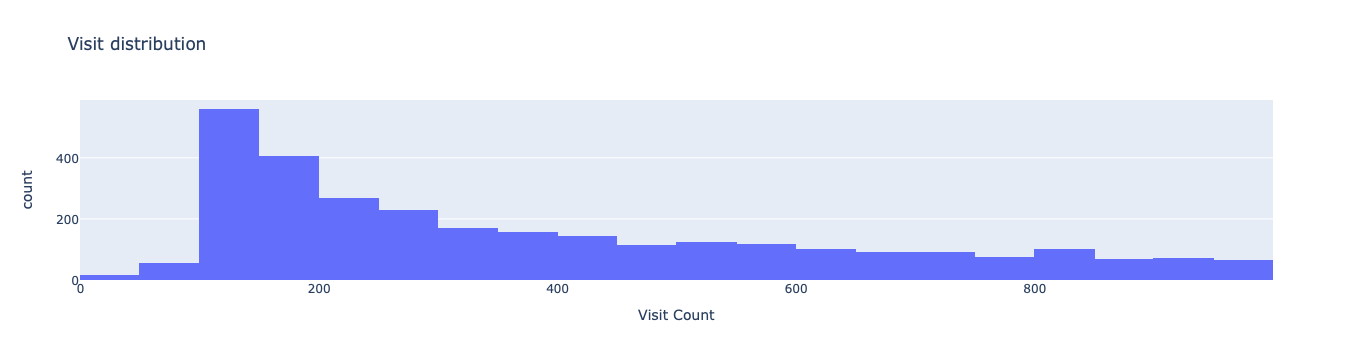

In [103]:
px.histogram(all_data,x='Visit Count', title='Visit distribution')

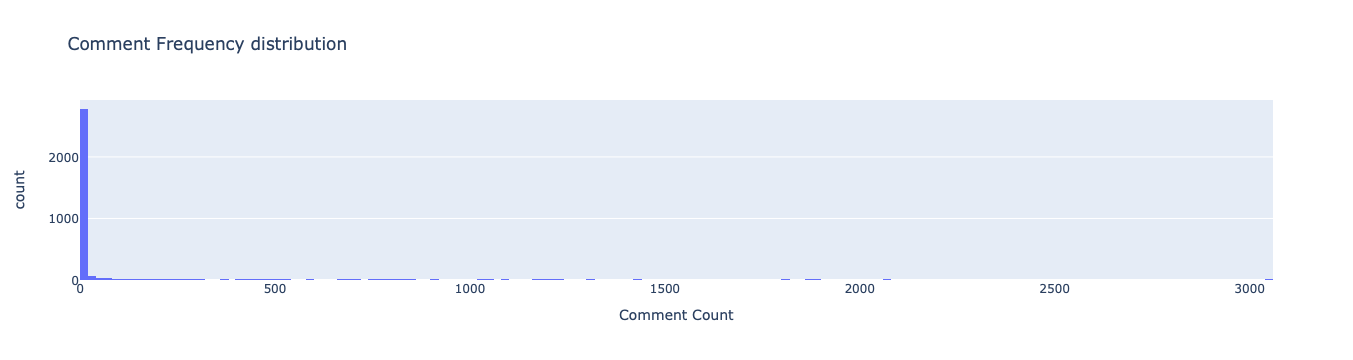

In [104]:
px.histogram(all_data,x='Comment Count',title='Comment Frequency distribution')

In [ ]:
from bs4 import BeautifulSoup

# Assuming 'all_data' is your DataFrame
# Extract and replace category names
all_data['Category'] = all_data['Category'].apply(lambda x: BeautifulSoup(x, 'html.parser').find('a').text.strip())



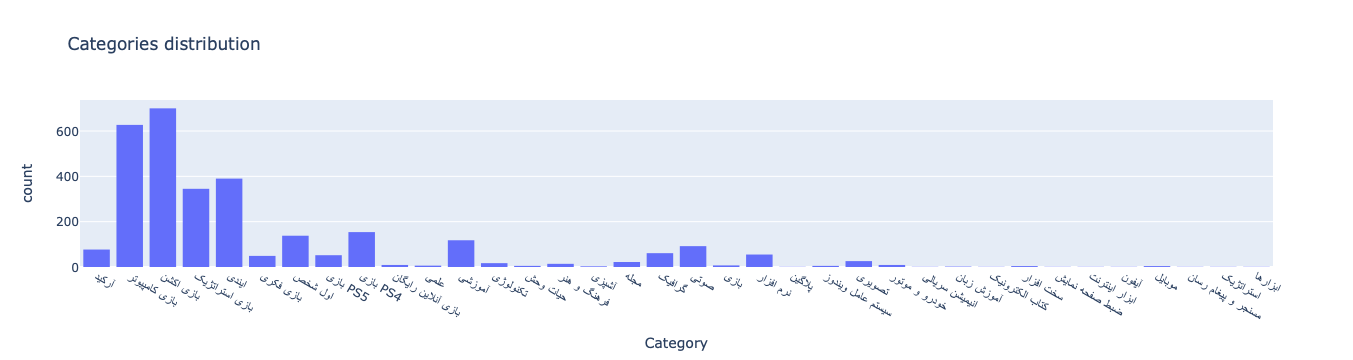

In [106]:
px.histogram(all_data,x='Category',title='Categories distribution')

In [107]:
unique_categories = all_data['Category'].unique()

# Print unique category names
for category in unique_categories:
    print(category)

آرکید
بازی کامپیوتر
بازی اکشن
بازی استراتژیک
ایندی
بازی فکری
اول شخص
بازی PS5
بازی PS4
بازی آنلاین رایگان
علمی
آموزشی
تکنولوژی
حیات وحش
فرهنگ و هنر
آشپزی
مجله
گرافیک
صوتی
بازی
نرم افزار
پلاگین
سیستم عامل ویندوز
تصویری
خودرو و موتور
انیمیشن سریالی
آموزش زبان
کتاب الکترونیک
سخت افزار
ضبط صفحه نمایش
ابزار اینترنت
آیفون
موبایل
مسنجر و پیغام رسان
استراتژیک
ابزارها


In [120]:
# Map categories to main categories
category_mapping = {
    'Game': ['بازی', 'اول شخص', 'ایندی', 'آرکید','استراتژیک'],
    'Multimedia': ['علمی','آموزشی', 'تکنولوژی', 'حیات وحش', 'فرهنگ و هنر', 'آشپزی', 'مجله', 'گرافیک', 'صوتی', 'تصویری', 'خودرو و موتور', 'انیمیشن سریالی', 'آموزش زبان', 'کتاب الکترونیک'],
    'Software': ['سخت افزار', 'نرم افزار', 'پلاگین', 'سیستم عامل ویندوز', 'ضبط صفحه نمایش', 'ابزار اینترنت', 'آیفون', 'موبایل', 'مسنجر و پیغام رسان', 'ابزارها']
}


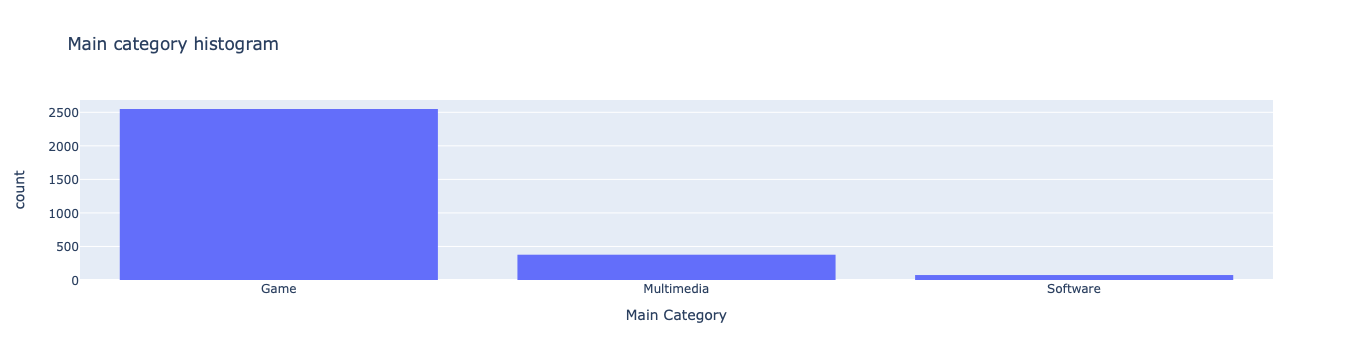

In [121]:
px.histogram(all_data,x='Main Category',title='Main category histogram')

## 3 Classification Beyond the Website

Now its time to extract the insights we need. For this part, you are free to use whichever technique, algorithm and library you desire. Just remember that the notebook should be able to provide the result locally, so avoid using online systems. Deliver the following items:

- Classify different categories of software and identify the top 5 hottest software categories and subcategories on the website based on the number of reviews and visits of softwares in that category. Explain your process and reasoning along with your results.

In [137]:

# 2. Feature Engineering
all_data['Engagement Metric'] = all_data['Visit Count'] + 100*all_data['Comment Count']


# Display the updated DataFrame
print(all_data.head())


                                                Name        Category  \
0     دانلود بازی TEKKEN 8 برای کامپیوتر – نسخه RUNE           آرکید   
1  دانلود بازی Assetto Corsa Competizione – GT2 P...   بازی کامپیوتر   
2  دانلود بازی The Long Dark – Tales from the Far...   بازی کامپیوتر   
3  دانلود بازی Warm Snow – The End Of Karma برای ...       بازی اکشن   
4  دانلود بازی Phantom Brigade برای کامپیوتر – نس...  بازی استراتژیک   

                                         Description  \
0  بازی Tekken 8 (تکن ۸) توسط بندای نامک توسعه یا...   
1  Assetto Corsa Competizione جدیدترین بازی رایان...   
2  بازی کامپیوتری The Long Dark در سبک بقا طراحی ...   
3  بازی Warm Snow به پدیده عجیبی می‌پردازد که به ...   
4  بازی Phantom Brigade یک تجربه تاکتیکی در سبک R...   

                 Date of Creation Author  Visit Count  Comment Count  \
0  Posted on ۱۴۰۲/۱۱/۰۵۱۴۰۲/۱۱/۰۶   حسین          226              0   
1  Posted on ۱۴۰۲/۱۱/۰۵۱۴۰۲/۱۱/۰۵   حسین          662             15   
2  Posted on ۱

/var/folders/y5/4ntn99k92d70gksjt9w9jgzr0000gn/T/ipykernel_10864/1577173824.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



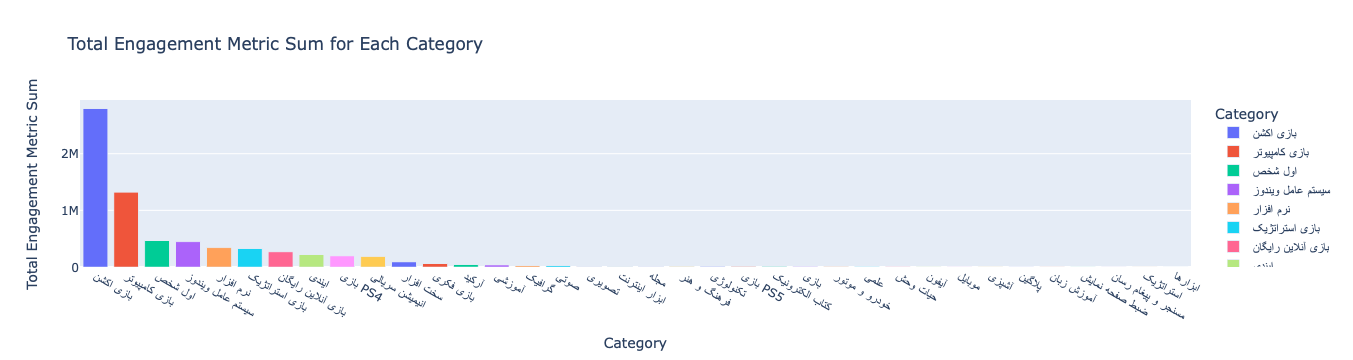

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



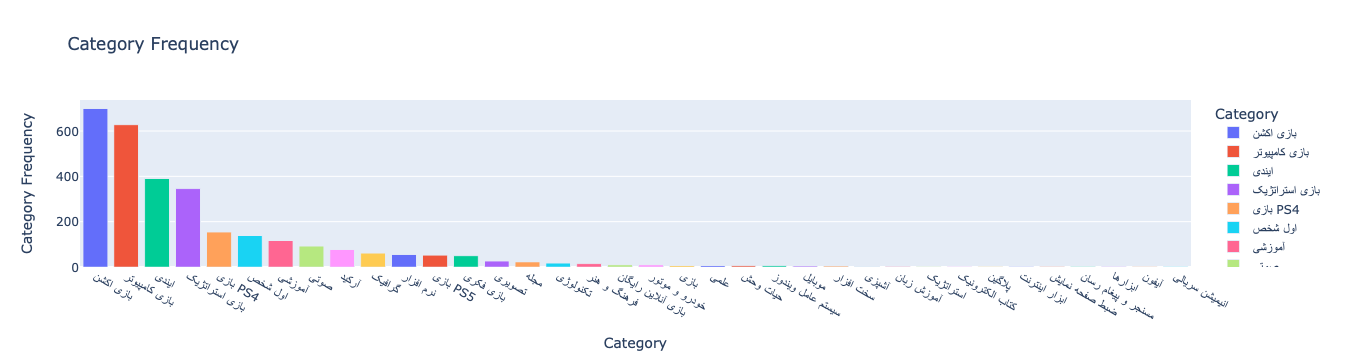

In [138]:
import plotly.express as px
all_data['Engagement Metric'] = pd.to_numeric(all_data['Engagement Metric'], errors='coerce')

# Group by 'Category' and calculate the total sum of 'Engagement Metric' for each category
category_sum = all_data.groupby('Category')['Engagement Metric'].sum().reset_index()

# Sort the DataFrame in descending order based on 'Engagement Metric'
category_sum = category_sum.sort_values(by='Engagement Metric', ascending=False)

# Plot histogram of the total sum of 'Engagement Metric' for each category
fig = px.bar(category_sum, x='Category', y='Engagement Metric',
             title='Total Engagement Metric Sum for Each Category',
             labels={'Engagement Metric': 'Total Engagement Metric Sum', 'Category': 'Category'},
             color='Category')

# Show the plot
fig.show()

# Count the frequency of each category
category_frequency = all_data['Category'].value_counts().reset_index()
category_frequency.columns = ['Category', 'Frequency']

# Sort the DataFrame in descending order based on 'Frequency'
category_frequency = category_frequency.sort_values(by='Frequency', ascending=False)

# Plot histogram of category frequency in decreasing order
fig = px.bar(category_frequency, x='Category', y='Frequency',
             title='Category Frequency',
             labels={'Frequency': 'Category Frequency', 'Category': 'Category'},
             color='Category')

# Show the plot
fig.show()

In [140]:
!pip install statsmodels


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 2.4 MB/s eta 0:00:0000:010:020m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 722.5 kB/s eta 0:00:00a 0:00:01


/var/folders/y5/4ntn99k92d70gksjt9w9jgzr0000gn/T/ipykernel_10864/3739209108.py:14: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



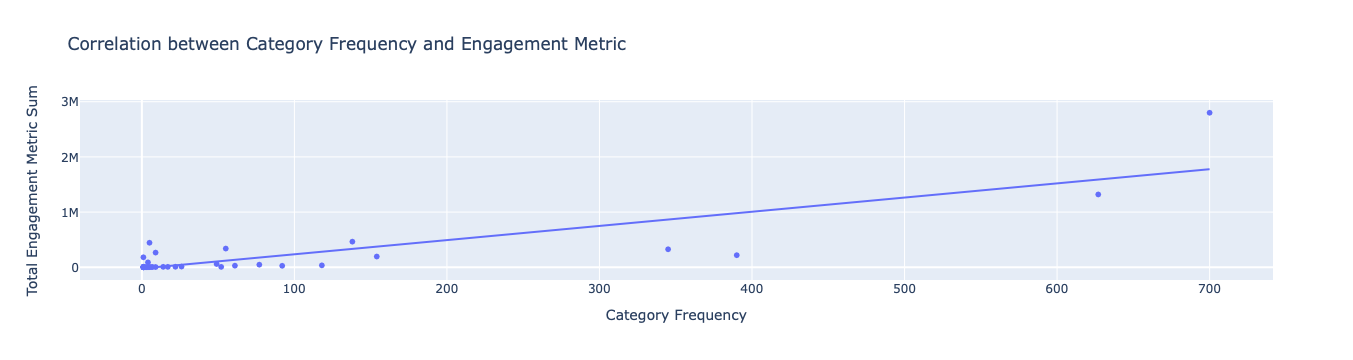

In [141]:
import plotly.express as px


all_data['Engagement Metric'] = pd.to_numeric(all_data['Engagement Metric'], errors='coerce')

# Count the frequency of each category
category_frequency = all_data['Category'].value_counts().reset_index()
category_frequency.columns = ['Category', 'Category Frequency']

# Sort the DataFrame in descending order based on 'Category Frequency'
category_frequency = category_frequency.sort_values(by='Category Frequency', ascending=False)

# Group by 'Category' and calculate the total sum of 'Engagement Metric' for each category
engagement_metric_sum = all_data.groupby('Category')['Engagement Metric'].sum().reset_index()

# Merge the two DataFrames on 'Category'
merged_df = pd.merge(category_frequency, engagement_metric_sum, on='Category')

# Plot scatter plot to show the correlation
fig = px.scatter(merged_df, x='Category Frequency', y='Engagement Metric',
                 title='Correlation between Category Frequency and Engagement Metric',
                 labels={'Engagement Metric': 'Total Engagement Metric Sum', 'Category Frequency': 'Category Frequency'},
                 trendline='ols')  # Add linear regression trendline

# Show the plot
fig.show()


## as you can see, there is a strong correlation between frequency of tags and engagement metric of the users that we calculated

- Your team wants to contact the admins of the website directly. Using the `author` field you gathered previously, find out which individuals are responsible for posting softwares of different categories. This is done by matching the authors with categories and finding out the `author`s most responsible for the latest posts in different categories. As an example, you may find that 70 percent of PS5 action games are posted by **John Doe**, so it is probable that this individual is tasked with finding out the latest games of PS5 and posting them on the website.

/var/folders/y5/4ntn99k92d70gksjt9w9jgzr0000gn/T/ipykernel_10864/238954272.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/y5/4ntn99k92d70gksjt9w9jgzr0000gn/T/ipykernel_10864/238954272.py:10: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



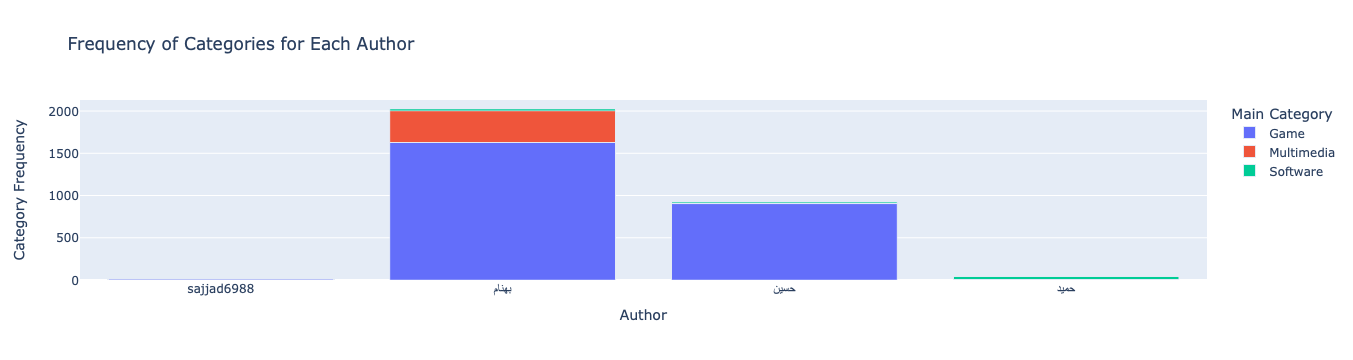

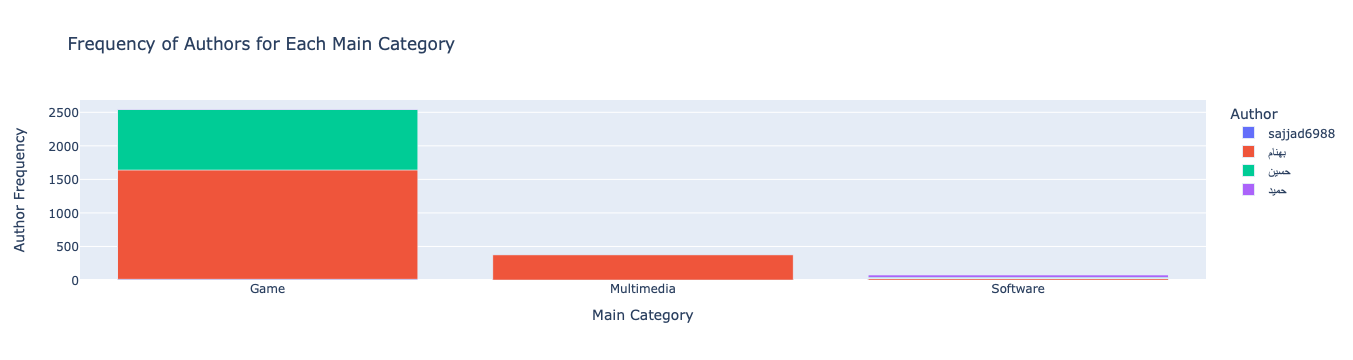

In [143]:
# Step 1: Find out which categories each author has written about the most
author_category_freq = all_data.groupby(['Author', 'Main Category']).size().reset_index(name='Frequency')

# Step 2: Plot the frequency of categories for each author
fig1 = px.bar(author_category_freq, x='Author', y='Frequency', color='Main Category',
              title='Frequency of Categories for Each Author',
              labels={'Frequency': 'Category Frequency', 'Author': 'Author'})

# Step 3: Find out the frequency of each author for each main category
category_author_freq = all_data.groupby(['Main Category', 'Author']).size().reset_index(name='Frequency')

# Step 4: Plot the frequency of author names for each main category
fig2 = px.bar(category_author_freq, x='Main Category', y='Frequency', color='Author',
              title='Frequency of Authors for Each Main Category',
              labels={'Frequency': 'Author Frequency', 'Main Category': 'Main Category'})

# Show the plots
fig1.show()
fig2.show()

- Find out and list five the sources you think the softwares and videos of the website are gathered from. Since `downloadha.com` is not a producer nor a developer, its objective is gathering different softwares from different vendors in one place. And it is most likely that it uses other websites as its source. Using the descriptions and analyzing it for entity names, it is possible to extract useful information about its possible sources. Explain your approach comprehensively and present your results.

In [150]:
!pip install hazm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.7/330.7 kB 418.2 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 1.4 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 478.3/478.3 kB 1.7 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 892.6/892.6 kB 1.1 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.7/227.7 kB 818.5 kB/s eta 0:00:00a 0:00:01
  Created wheel for flashtext: filename=flashtext-2.7-py2.py3-none-any.whl size=9297 sha256=a0c126511b077eec90df7021069e497fe566b73d6bc14d5b4656b15f7400681f
  Stored in directory: /Users/alinikkhah/Library/Caches/pip/wheels/49/20/47/f03dfa8a7239c54cbc44ff7389eefbf888d2c1873edaaec888
  Created wheel for python-crfsuite: filename=python_crfsuite-0.9.10-cp311-cp311-macosx_10_9_universal2.whl size=379282 sha256=b8a0fc8174c62df8e762e1bffe429d44dacb17cb4809859416218ad

In [ ]:
from hazm import Normalizer, sent_tokenize, word_tokenize, POSTagger, DependencyParser, Lemmatizer

# Load necessary components from hazm
normalizer = Normalizer()
tagger = POSTagger(model='resources/postagger.model')
lemmatizer = Lemmatizer()

# Function to process Persian text
def process_persian_text(text):
    # Normalize the text
    normalized_text = normalizer.normalize(text)
    
    # Tokenize into sentences and words
    sentences = sent_tokenize(normalized_text)
    words = [word_tokenize(sent) for sent in sentences]
    
    # Part-of-speech tagging
    pos_tags = [tagger.tag(sent) for sent in words]
    
    # Lemmatization
    lemmatized_words = [[lemmatizer.lemmatize(word, tag) for word, tag in sent] for sent in pos_tags]
    
    return sentences, words, pos_tags, lemmatized_words

# Example usage
persian_text = "متن نمونه به فارسی"
sentences, words, pos_tags, lemmatized_words = process_persian_text(persian_text)

# Display the results
print("Sentences:", sentences)
print("Words:", words)
print("POS Tags:", pos_tags)
print("Lemmatized Words:", lemmatized_words)
